###Today's topic is RNN

RNN can handle diverse task

Today, we implement below models

1. many-to-many RNN
2. many-to-one RNN

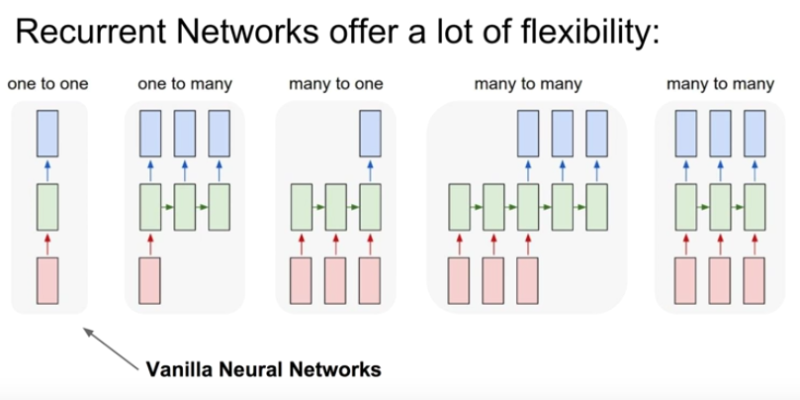

##1. Word-RNN(Recurrent Neural Network)

####Many-to-Many RNN
###we are implemnt the text generation rnn
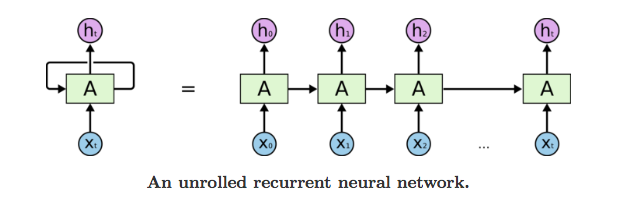

In [1]:
# import pakages
import os
import torch


##1-1. Data preprocessing

In [2]:
#Simple sentence data.
sentence = "All grownup were once children, although few of them remember it".split()
#Make the vokabulary
vocab = list(set(sentence))
print(vocab)

['it', 'All', 'grownup', 'few', 'them', 'remember', 'children,', 'of', 'although', 'once', 'were']


In [3]:
#We use the word indexing,it is converted to one-hot encoding inside the model .
#This dict transfroms word to index(number)
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}
word2index['<unk>']=0
print(word2index)

{'it': 1, 'All': 2, 'grownup': 3, 'few': 4, 'them': 5, 'remember': 6, 'children,': 7, 'of': 8, 'although': 9, 'once': 10, 'were': 11, '<unk>': 0}


In [4]:
word2index['of']

8

In [5]:
#This dict transfroms index to number(number)
index2word = {v: k for k, v in word2index.items()}
print(index2word)

{1: 'it', 2: 'All', 3: 'grownup', 4: 'few', 5: 'them', 6: 'remember', 7: 'children,', 8: 'of', 9: 'although', 10: 'once', 11: 'were', 0: '<unk>'}


In [6]:
index2word[5]

'them'

In [7]:
#Function to make the input data(X) and the labels(Y)
def build_data(sentence, word2index):
  encoded = [word2index[token] for token in sentence] # transforms word to index
  input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
  input_seq = torch.LongTensor(input_seq).unsqueeze(0)
  label_seq = torch.LongTensor(label_seq).unsqueeze(0)
  return input_seq, label_seq

In [8]:
# 질문: 여기서 y는 어떻게 지정된건가요?? grownup ~ 문장을 따로 넣어준 것도 아닌데...
x, y = build_data(sentence, word2index)

In [9]:
print(f'Input data: {x} sentence: All grownup were once children, although few of them remember \nlabes: {y} sentence: grownup were once children, although few of them remember it')

Input data: tensor([[ 2,  3, 11, 10,  7,  9,  4,  8,  5,  6]]) sentence: All grownup were once children, although few of them remember 
labes: tensor([[ 3, 11, 10,  7,  9,  4,  8,  5,  6,  1]]) sentence: grownup were once children, although few of them remember it


###Word Embedding

In order to handle text data, a process of changing word to a number through embedding is required.

There are so many embedding methods, and one hot encoding that we learned is also one of the embedding methods.

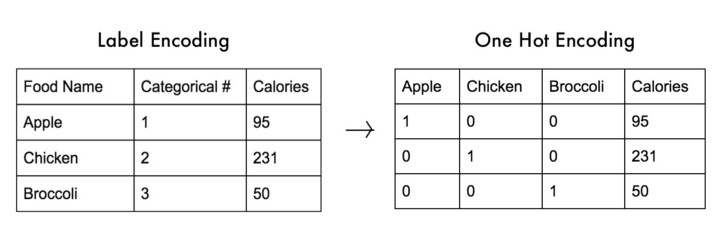


In [10]:
embedding_function = torch.nn.Embedding(num_embeddings=len(word2index), embedding_dim = 5)
embedding_function(x)

tensor([[[ 0.1137,  1.8077, -0.0050,  0.9553,  0.6151],
         [-2.2043, -0.4708,  1.4414, -1.3510,  1.2166],
         [ 1.2862, -1.1783, -1.0692, -2.7744, -0.1044],
         [ 1.4508,  1.5304, -0.7296, -0.6216, -0.7982],
         [ 0.2423,  0.3477,  1.1948,  0.7798,  0.0235],
         [ 0.1122, -1.6514, -0.3670, -1.0710, -0.3589],
         [-0.8444,  0.3996,  0.9733,  1.1418, -2.0349],
         [-1.0915, -0.6798,  0.4575,  0.5202,  0.6704],
         [-0.3351,  0.7374,  1.0202,  0.2398,  0.9472],
         [-1.2436, -0.1434,  0.7663, -1.1408, -0.2746]]],
       grad_fn=<EmbeddingBackward0>)

##1-2. Implenment the Many-to-Many RNN model

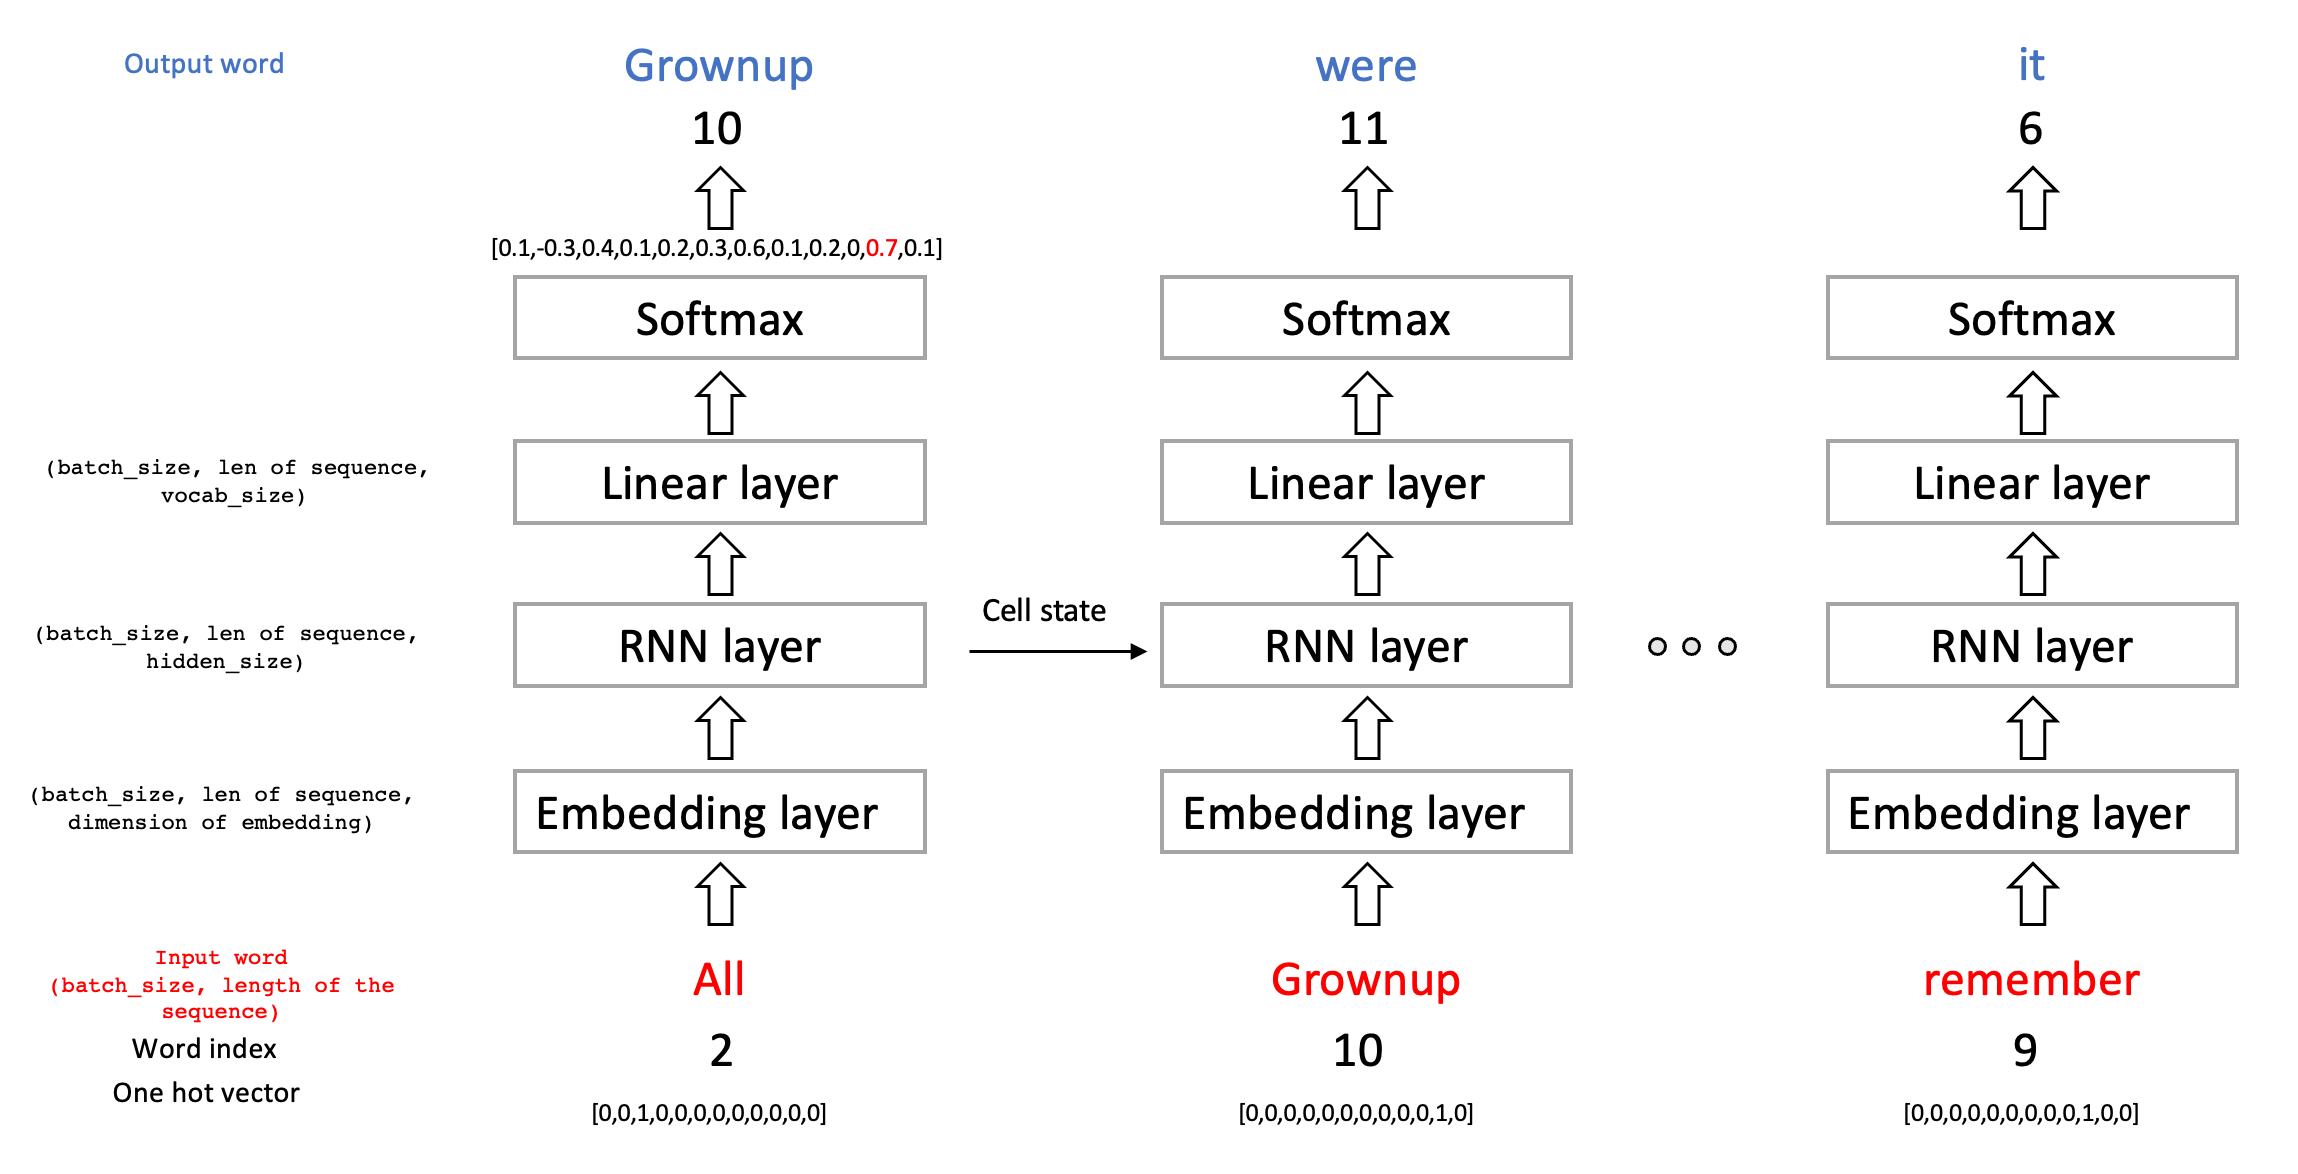

In [11]:
class RNN_model(torch.nn.Module):
  #vocab_size = size of the using word
  #hidden_size = size of the RNN's output
  def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
    super(RNN_model, self).__init__()

    #Embedding layer
    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)

    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=batch_first)

    #linear layer
    self.linear = torch.nn.Linear(hidden_size, vocab_size)
  
  def forward(self, x):
    #1. Embedding layer
    #size of the data: (batch_size, length of the sequence) 
    #-> (batch_size, lenth of the sequence, dimension of embedding)
    y = self.embedding_layer(x)

    #2. RNN layer
    #size of the data: (batch_size, length of the sequence, dimension of embedding)
    #-> y: (batch_size, length of the sequence, hidden_size), hidden: (1, batch_size, hidden_size)
    y, hidden = self.rnn_layer(y)

    #3. Linear layer
    #size of the data: (batch_size, length of the sequence, hidden_size)
    #-> (batch_size, length of the sequence, vocab_size)
    y = self.linear(y)

    #Size of the return value: (batch_size*lenth of the sequence, vocab_size)
    return y.view(-1, y.size(2))

##1-3. Train the RNN model

In [12]:
#hyper parameter
vocab_size = len(word2index) 
input_size = 5 
hidden_size = 20
epochs = 200

In [13]:
model = RNN_model(vocab_size, input_size, hidden_size, batch_first=True)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [14]:
#This is the function to decode the model result into word.
decode = lambda y: [index2word.get(x) for x in y]

In [15]:
#Befor the learning, observe the result
output = model(x)
pred = output.softmax(-1).argmax(-1).tolist()

print(f'Law x: All grownup were once children, although few of them remember')
print(f'Result of the rnn model: {" ".join(decode(pred))}')

Law x: All grownup were once children, although few of them remember
Result of the rnn model: <unk> <unk> <unk> few although <unk> them <unk> <unk> <unk>


In [16]:
#Training
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.view(-1))
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(['All']+ decode(pred)))
        print()

Epoch: 20, Loss: 2.247729778289795
All although although were few although <unk> of <unk> remember it

Epoch: 40, Loss: 1.978857398033142
All grownup were were it although few of them remember it

Epoch: 60, Loss: 1.6654398441314697
All grownup were once it although few of them remember it

Epoch: 80, Loss: 1.335233211517334
All grownup were once children, although few of them remember it

Epoch: 100, Loss: 1.0258053541183472
All grownup were once children, although few of them remember it

Epoch: 120, Loss: 0.7661492228507996
All grownup were once children, although few of them remember it

Epoch: 140, Loss: 0.5652772784233093
All grownup were once children, although few of them remember it

Epoch: 160, Loss: 0.42036762833595276
All grownup were once children, although few of them remember it

Epoch: 180, Loss: 0.3189564347267151
All grownup were once children, although few of them remember it

Epoch: 200, Loss: 0.24802669882774353
All grownup were once children, although few of them 

###Problem 1(20pt)
###Train the RNN model using your sentence

*You have to implement new RNN model

*The length of the sentence must be at least 10 words.

*There must be at least one duplicate word.

*Don't use all the punctuation marks such as '.,!?'.

In [17]:
#Write the code
sentence = "Apple is the most emotional smart machine company making smart phone".split()

vocab = list(set(sentence))
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}
word2index['<unk>']=0
index2word = {v: k for k, v in word2index.items()}

def build_data(sentence, word2index):
  encoded = [word2index[token] for token in sentence] # transforms word to index
  input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
  input_seq = torch.LongTensor(input_seq).unsqueeze(0)
  label_seq = torch.LongTensor(label_seq).unsqueeze(0)
  return input_seq, label_seq

x, y = build_data(sentence, word2index)

vocab_size = len(word2index)
input_size = 5
hidden_size = 20
epochs = 200

class RNN_model(torch.nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
    super(RNN_model, self).__init__()

    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)

    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=batch_first)

    self.linear = torch.nn.Linear(hidden_size, vocab_size)
  
  def forward(self, x):
    y = self.embedding_layer(x)

    y, hidden = self.rnn_layer(y)

    y = self.linear(y)

    return y.view(-1, y.size(2))
  
model = RNN_model(vocab_size, input_size, hidden_size, batch_first=True)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())
decode = lambda y: [index2word.get(x) for x in y]

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.view(-1))
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(['Apple']+ decode(pred)))
        print()

Epoch: 20, Loss: 2.1346583366394043
Apple machine smart smart machine smart machine company smart smart phone

Epoch: 40, Loss: 1.87309992313385
Apple emotional the smart emotional smart machine company making smart phone

Epoch: 60, Loss: 1.5660792589187622
Apple emotional the most emotional smart machine company making smart phone

Epoch: 80, Loss: 1.2639697790145874
Apple emotional the most emotional smart machine company making smart phone

Epoch: 100, Loss: 0.9807487726211548
Apple is the most emotional smart machine company making smart phone

Epoch: 120, Loss: 0.7362945079803467
Apple is the most emotional smart machine company making smart phone

Epoch: 140, Loss: 0.5419928431510925
Apple is the most emotional smart machine company making smart phone

Epoch: 160, Loss: 0.3970779776573181
Apple is the most emotional smart machine company making smart phone

Epoch: 180, Loss: 0.2941944897174835
Apple is the most emotional smart machine company making smart phone

Epoch: 200, Loss

##2. Sentence classification RNN

####Many to one RNN

In [18]:
#import the packages
import os
#torchtext is package to provide diverse text data
import torchtext.legacy as torchtext

In [19]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using device:", DEVICE)

Using device: cuda


##2-1. Load the IMDB data

IMDB data consists of text data about movie reviews.

Labels are whether reviews are positive or negative.

IMDB is data for learning a classification model that classifies movie reviews as positive or negative.

In [20]:
#It is an instructor for transforming text data into a tensor.
TEXT = torchtext.data.Field(sequential=True, batch_first=True, lower=True)
LABEL = torchtext.data.Field(sequential=False, batch_first=True)

In [21]:
#Load the IMDB dataset
trainset, testset = torchtext.datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:09<00:00, 8.77MB/s]


In [22]:
print(f'Length of trainset: {len(trainset)} Length of testset: {len(testset)}')

Length of trainset: 25000 Length of testset: 25000


In [23]:
#Observe the data
pos_data = vars(trainset[0])
neg_data = vars(trainset[20000])
print(f"--Positive data-- \n Sentence: {' '.join(pos_data['text'])}\n Label: {pos_data['label']}")
print()
print(f"--Negative data-- \n Sentence: {' '.join(neg_data['text'])}\n Label: {neg_data['label']}")

--Positive data-- 
 Sentence: "roman troy moronie" is my comment on the movie. what else is there to say?<br /><br />this character really brings out the moron in moronie. a tough gangster with an inability to pronounce profane words, well, it seems that it would have been frustrating to be tough and yet not be able to express oneself intelligently. <br /><br />roman moronie will go down in the annals of movie history as one of the greatest of all morons.<br /><br />there is of course great comedy among the other characters. michael keaton is f.a.h. and so is joe piscipo.<br /><br />i just like the fact that moronie kept the movie from an "r" rating because he could not pronounce profanity.
 Label: pos

--Negative data-- 
 Sentence: well...the movie was a fun watch. the main problem with this movie is the fact that it goes against everything that most vampire myths abide by. like vampires that walk in the sunlight. though there are parts that just make you enjoy the way society makes m

In [24]:
#Make the vocabulary set
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

In [25]:
vocab_size = len(TEXT.vocab)
print(f'Size of the vocabulary set: {vocab_size}')

Size of the vocabulary set: 46159


In [26]:
#Observe the words
# TEXT.vocab.stoi

In [27]:
#Split the trainset into trainset and validation set
trainset, valset = trainset.split(split_ratio=0.8)

In [28]:
#Make the data loader
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=64,
        shuffle=True, repeat=False)

In [29]:
#Since the length of the sentence is different, the size of the data varies from batch to batch
batch = next(iter(train_iter))
print(f'Shape of first batch: {batch.text.shape}')
batch = next(iter(train_iter))
print(f'Shape of second batch: {batch.text.shape}')

#Reset the data loader to learn the observed data as well
train_iter, val_iter, test_iter =torchtext.data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=64,
        shuffle=True, repeat=False)

Shape of first batch: torch.Size([64, 984])
Shape of second batch: torch.Size([64, 709])


##2-2. Implenment the RNN model

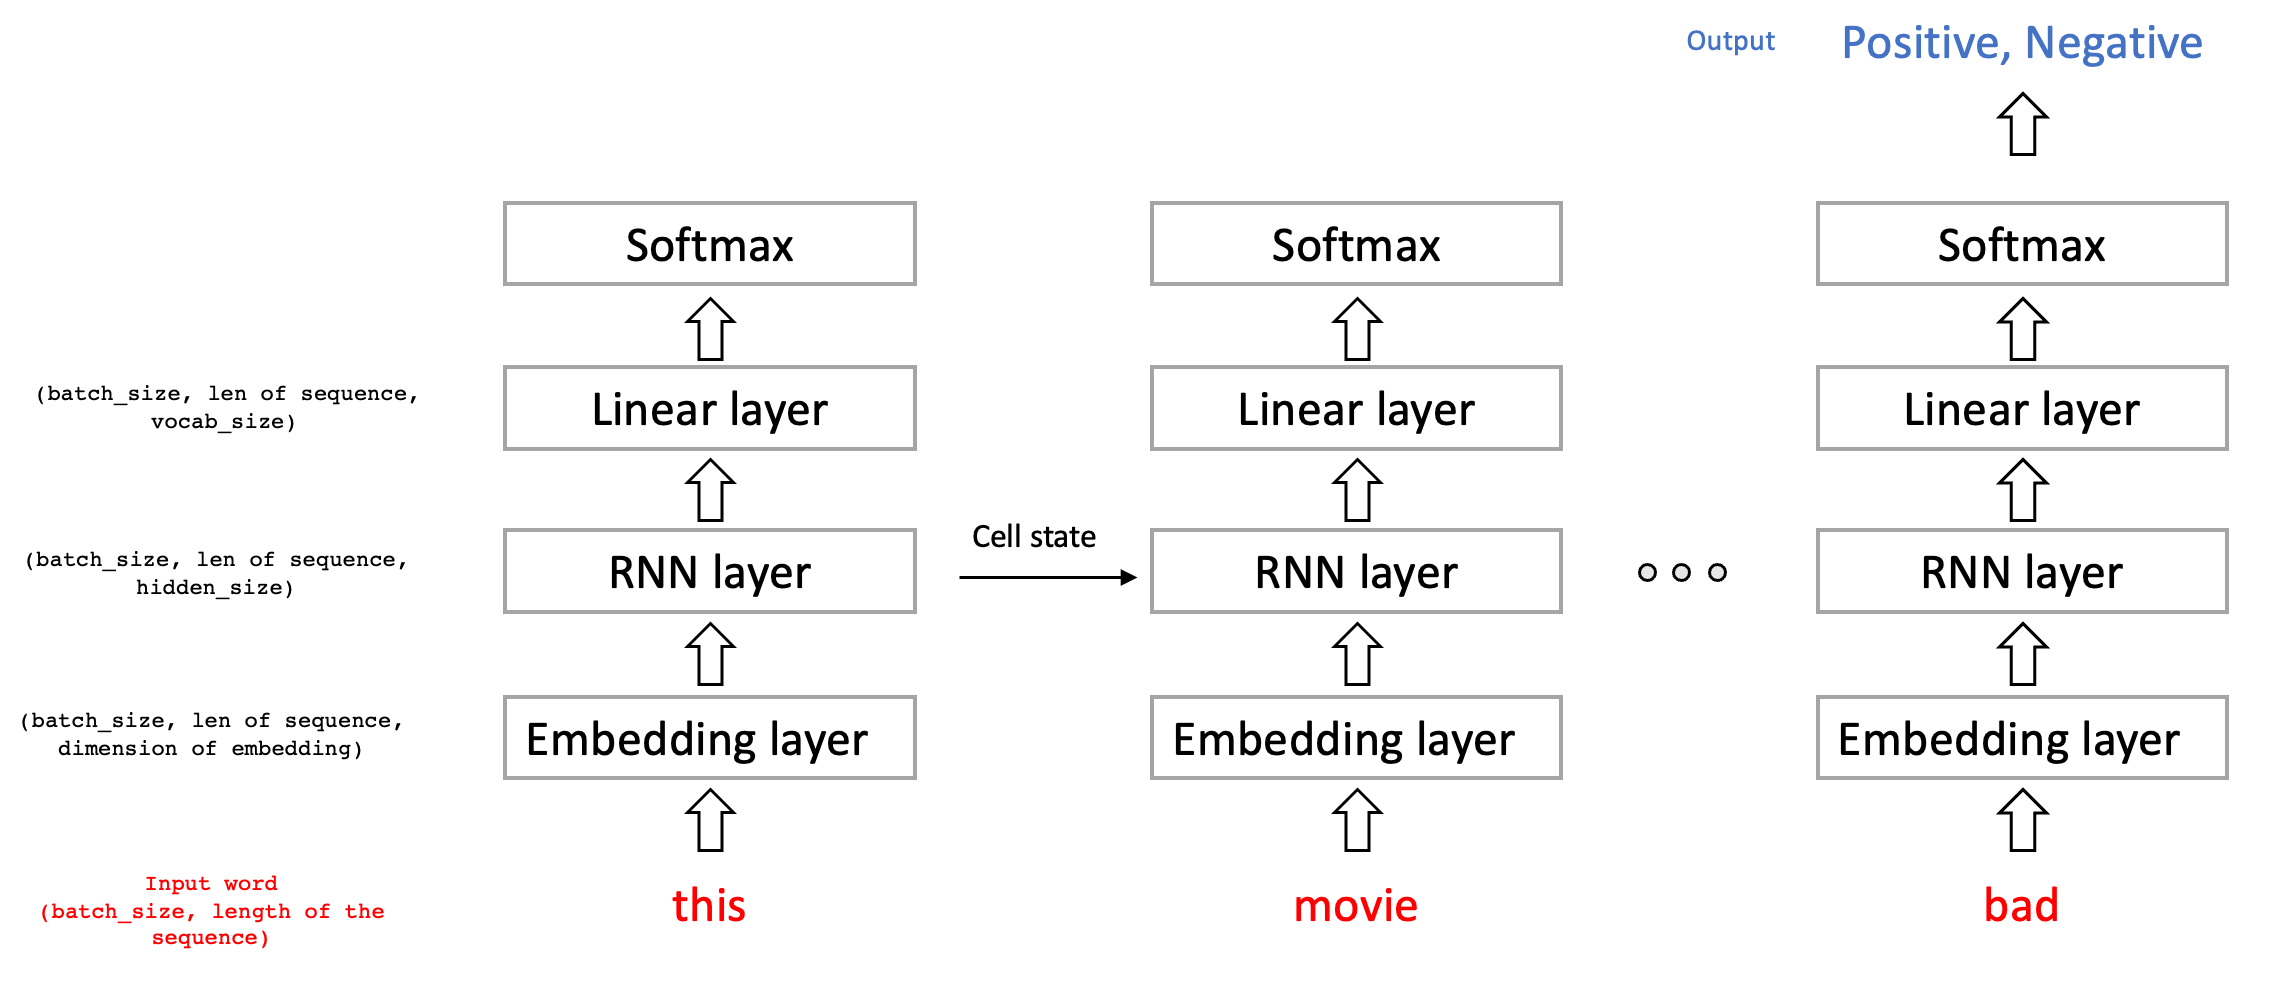

In [30]:
class classification_RNN(torch.nn.Module):
  def __init__(self, vocab_size, input_size, n_labels, hidden_size, batch_first=True):
    super(classification_RNN, self).__init__()
    self.vocab_size = vocab_size
    self.input_size = input_size
    self.hidden_size = hidden_size

    #Embedding layer
    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)

    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=batch_first)

    #linear layer
    self.linear = torch.nn.Linear(hidden_size, n_labels)


  def forward(self, x):
    #1. Embedding layer
    #size of the data: (batch_size, length of the sequence) 
    #-> (batch_size, length of the sequence, dimension of embedding)
    y = self.embedding_layer(x)

    #2. RNN layer
    #size of the data: (batch_size, length of the sequence, dimension of embedding)
    #-> y: (batch_size, lenth of the sequence, hidden_size), hidden: (1, batch_size, hidden_size)
    y, hidden = self.rnn_layer(y)

    #Using only last time step result
    #y = (batch_size, hidden_size)
    y = y[:,-1,:]

    #3. Linear layer
    #size of the data: (batch_size, hidden_size)
    #-> (batch_size, n_labels)
    y = self.linear(y)

    #Size of the return value: (batch_size*length of the sequence, vocab_size)
    return y

##2-3. Train the RNN model

In [31]:
#hyper parameter
lr = 0.001
epochs = 10

In [32]:
model = classification_RNN(vocab_size=vocab_size, input_size = 128, n_labels=2, hidden_size=256).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [33]:
#train function
def train(model, optimizer, train_iter):
  for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1)  #transforms the labels into (0, 1)
    optimizer.zero_grad()

    logit = model(x)
    loss = torch.nn.functional.cross_entropy(logit, y)
    loss.backward()
    optimizer.step()

In [34]:
#Evaluate function
def evaluate(model, val_iter):
  corrects, total_loss = 0, 0
  for batch in val_iter:
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1) #transforms the labels into (0, 1)
    logit = model(x)
    loss = torch.nn.functional.cross_entropy(logit, y, reduction='sum')
    total_loss += loss.item()
    corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
  size = len(val_iter.dataset)
  avg_loss = total_loss / size
  avg_accuracy = 100.0 * corrects / size
  return avg_loss, avg_accuracy

In [35]:
for e in range(1, epochs+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)
    print(f"Epoch: {e}, Loss of validation: {val_loss} Accuracy of validation: {val_accuracy}")

Epoch: 1, Loss of validation: 0.720956044960022 Accuracy of validation: 50.89999771118164
Epoch: 2, Loss of validation: 0.6970062908172607 Accuracy of validation: 50.53999710083008
Epoch: 3, Loss of validation: 0.6982552304267883 Accuracy of validation: 50.39999771118164
Epoch: 4, Loss of validation: 0.6961847716331482 Accuracy of validation: 50.2599983215332
Epoch: 5, Loss of validation: 0.6980742703437806 Accuracy of validation: 49.36000061035156
Epoch: 6, Loss of validation: 0.6987635351181031 Accuracy of validation: 49.81999969482422
Epoch: 7, Loss of validation: 0.6990718773841857 Accuracy of validation: 49.97999954223633
Epoch: 8, Loss of validation: 0.7083915672302246 Accuracy of validation: 50.29999923706055
Epoch: 9, Loss of validation: 0.7030996838569641 Accuracy of validation: 49.939998626708984
Epoch: 10, Loss of validation: 0.7045843058586121 Accuracy of validation: 50.34000015258789


In [36]:
test_loss, test_acc = evaluate(model, test_iter)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Test loss: 0.6940189872741699, Test accuracy: 58.70399856567383


###Problem 2(20pt)
###Implement LSTM model and Train that model

*The test accuracy of your lstm model should be higher than that of the rnn model.

*Fill the ### blank of below model.

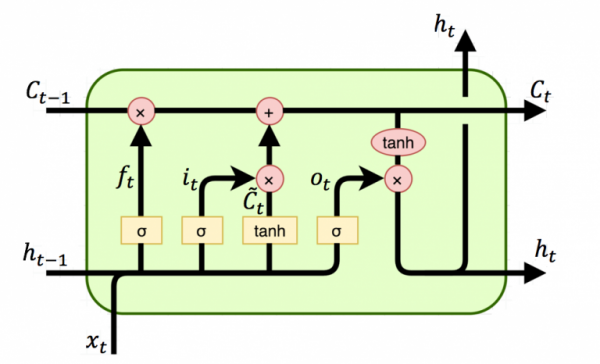

In [37]:
class LSTM(torch.nn.Module):
  def __init__(self, vocab_size, input_size, n_labels, hidden_size, num_layers = 1, batch_first=True):
    super(LSTM, self).__init__()
    self.vocab_size = vocab_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #Embedding layer
    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)

    #RNN layer
    self.lstm_layer = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                                    batch_first=batch_first)

    #linear layer
    self.linear = torch.nn.Linear(hidden_size, n_labels)

  def forward(self, x):
    #1. Embedding layer
    #size of the data: (batch_size, lenth of the sequence) 
    #-> (batch_size, lenth of the sequence, dimension of embedding)
    y = self.embedding_layer(x)

    #Initial hidden state
    h_0 = torch.zeros((self.num_layers, y.shape[0], self.hidden_size)).to(DEVICE)

    #Initial cell state
    c_0 = torch.zeros((self.num_layers, y.shape[0], self.hidden_size)).to(DEVICE)

    #2. LSTM layer
    #size of the data: (batch_size, lenth of the sequence, dimension of embedding)
    #-> h_n, c_0 = (num_layers, batch size, hidden_size)
    hidden_states, (h_n , c_n) = self.lstm_layer(y, (h_0, c_0))

    #h_n = (num_layers*batch size, hidden_size)
    h_n = h_n.view(h_n.shape[1] ,-1)

    #3. Linear layer
    #size of the data: (batch_size, hidden_size)
    #-> (batch_size, n_labels)
    result = self.linear(h_n)

    #Size of the return value: (batch_size, n_labels)
    return result

In [38]:
model = LSTM(vocab_size=vocab_size, input_size=128, n_labels=2, hidden_size=256).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [39]:
#train function
def train(model, optimizer, train_iter):
  for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1)  #transforms the labels into (0, 1)
    optimizer.zero_grad()

    logit = model(x)
    loss = torch.nn.functional.cross_entropy(logit, y)
    loss.backward()
    optimizer.step()

#Evaluate function
def evaluate(model, val_iter):
  corrects, total_loss = 0, 0
  for batch in val_iter:
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1) #transforms the labels into (0, 1)
    logit = model(x)
    loss = torch.nn.functional.cross_entropy(logit, y, reduction='sum')
    total_loss += loss.item()
    corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
  size = len(val_iter.dataset)
  avg_loss = total_loss / size
  avg_accuracy = 100.0 * corrects / size
  return avg_loss, avg_accuracy

In [40]:
for e in range(1, epochs+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)
    print(f"Epoch: {e}, Loss of validation: {val_loss} Accuracy of validation: {val_accuracy}")

Epoch: 1, Loss of validation: 0.6936015442848206 Accuracy of validation: 50.29999923706055
Epoch: 2, Loss of validation: 0.6968371255874634 Accuracy of validation: 50.71999740600586
Epoch: 3, Loss of validation: 0.7027020088195801 Accuracy of validation: 51.02000045776367
Epoch: 4, Loss of validation: 0.7046018007278443 Accuracy of validation: 51.37999725341797
Epoch: 5, Loss of validation: 0.7119836439132691 Accuracy of validation: 51.439998626708984
Epoch: 6, Loss of validation: 0.7214134327888488 Accuracy of validation: 52.87999725341797
Epoch: 7, Loss of validation: 0.7224882016181946 Accuracy of validation: 53.31999969482422
Epoch: 8, Loss of validation: 0.6932737064361573 Accuracy of validation: 58.39999771118164
Epoch: 9, Loss of validation: 0.5149817811965942 Accuracy of validation: 76.9000015258789
Epoch: 10, Loss of validation: 0.3985435454368591 Accuracy of validation: 84.0


In [41]:
test_loss, test_acc = evaluate(model, test_iter)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Test loss: 0.39576966331481933, Test accuracy: 83.52399444580078
